# Modelo con función de pérdida ponderada

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [4]:
# Resized images directory
dir_2020_images = "/kaggle/input/resizedsiimisic/test_resized/"

# CSV file
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/test.csv')
#test_df = pd.read_csv('/kaggle/input/resizedsiimisic/test.csv')

In [5]:
print("Train shape:", train_df.shape)

Train shape: (32531, 6)


## <font color=red>2. </font>Función de pérdida ponderada

In [6]:
train_df.target.value_counts().rename_axis('Tipo').reset_index(name='Total de muestras')

,Tipo,Total de muestras
0,0,31956
1,1,575


In [7]:
from sklearn.utils import class_weight as cw

y_train = train_df['target'].to_numpy()
class_weight_ = cw.compute_class_weight('balanced',
                                        np.unique(y_train),
                                        y_train)
print(class_weight_)

[ 0.50899675 28.28782609]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
class_weight_ = {0:class_weight_[0], 1:class_weight_[1]}

In [9]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [10]:
# Split into train, validation test and calibration sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, 
                                                    test_size=0.4,
                                                    stratify=y_test,
                                                    random_state=42)


print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("Conjunto de calibracion:", X_calib.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba:", Counter(y_test))
print("Distribucion de calibracion:", Counter(y_calib))

Conjunto de train: (20819, 6)
Conjunto de validacion: (5205, 6)
Conjunto de prueba: (3904, 6)
Conjunto de calibracion: (2603, 6)
-----------------------
Distribucion de train -> Counter({0: 20451, 1: 368})
Distribucion de validacion -> Counter({0: 5113, 1: 92})
Distribucion de prueba: Counter({0: 3835, 1: 69})
Distribucion de calibracion: Counter({0: 2557, 1: 46})


In [11]:
X_train.to_csv('/kaggle/working/train.csv', index=False)
X_val.to_csv('/kaggle/working/val.csv', index=False)
X_calib.to_csv('/kaggle/working/calib.csv', index=False)
X_test.to_csv('/kaggle/working/test.csv', index=False)

In [12]:
X_train["target"] = X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_calib["target"] = X_calib['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

## <font color=red>3. </font>Crear y entrenar el modelo

In [13]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121 
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [16]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=dir_2020_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_2020_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

calib_generator = datagen.flow_from_dataframe(
    dataframe=X_calib,
    directory=dir_2020_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_2020_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_CALIB = calib_generator.n//calib_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 20819 validated image filenames belonging to 2 classes.
Found 5205 validated image filenames belonging to 2 classes.
Found 2603 validated image filenames belonging to 2 classes.
Found 3904 validated image filenames belonging to 2 classes.


In [17]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

In [18]:
inputs = Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model_weighted = Model(inputs=inputs, outputs=predictions)

In [19]:
model_weighted.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [20]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      AUC(name='auc')
]

In [21]:
checkpoint_filepath = '/kaggle/working/weighted_model_2020.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_auc',
                                            mode='max',
                                            verbose=1,
                                            save_best_only=True)

In [27]:
model_weighted.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

In [29]:
model_weighted.fit(train_generator,  
                   validation_data=valid_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN, 
                   validation_steps=STEP_SIZE_VALID,
                   callbacks=[model_checkpoint_callback],
                   class_weight = class_weight_,
                   epochs=100)

Epoch 1/100
650/650 [==============================] - 220s 338ms/step - loss: 2.5147 - tp: 174.0000 - fp: 11473.0000 - tn: 8948.0000 - fn: 192.0000 - auc: 0.4543 - val_loss: 0.7008 - val_tp: 91.0000 - val_fp: 5093.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to /kaggle/working/weighted_model_2020.h5
Epoch 2/100
650/650 [==============================] - 191s 294ms/step - loss: 0.7778 - tp: 226.0000 - fp: 12885.0000 - tn: 7534.0000 - fn: 142.0000 - auc: 0.4994 - val_loss: 0.7015 - val_tp: 91.0000 - val_fp: 5093.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: val_auc did not improve from 0.50000
Epoch 3/100
650/650 [==============================] - 191s 294ms/step - loss: 0.7603 - tp: 192.0000 - fp: 9831.0000 - tn: 10588.0000 - fn: 176.0000 - auc: 0.5220 - val_loss: 0.1312 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5093.0000 - val_fn: 91.0000 - val_auc: 0.6974



## <font color=red>4. </font>Evaluar el modelo

In [30]:
eval_metrics = model_weighted.evaluate(test_generator,
                                       steps=STEP_SIZE_TEST,
                                       return_dict=True,
                                       use_multiprocessing=False,
                                       verbose=1)

122/122 [==============================] - 31s 257ms/step - loss: 0.7502 - tp: 62.0000 - fp: 1873.0000 - tn: 1962.0000 - fn: 7.0000 - auc: 0.7309


In [31]:
calib_labels = calib_generator.classes
test_labels = test_generator.classes

predict_calib = model_weighted.predict(calib_generator,
                                       verbose=1)
predict_test = model_weighted.predict(test_generator,
                                      verbose=1)

122/122 [==============================] - 9s 73ms/step


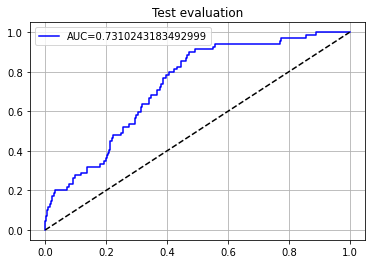

In [32]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(test_labels, predict_test.ravel())
auc = metrics.roc_auc_score(test_labels, predict_test.ravel())
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Finalmente, se observa la matriz de confusión para el conjunto de prueba y calibración.

In [33]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(test_labels, np.where(np.array(predict_test.ravel()) > 0.5, 1, 0))
cm_test

array([[1962, 1873],
       [   7,   62]])

<AxesSubplot:>

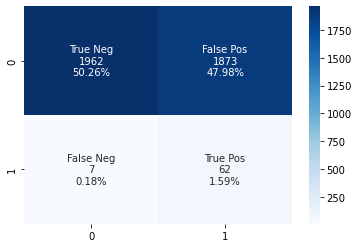

In [34]:
import seaborn as sns

cm = [cm_test[0][0], cm_test[0][1], cm_test[1][0], cm_test[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

In [35]:
cm_calib = confusion_matrix(calib_labels, np.where(np.array(predict_calib.ravel()) > 0.5, 1, 0))
cm_calib

array([[1255, 1302],
       [   2,   44]])

Calibration dataset


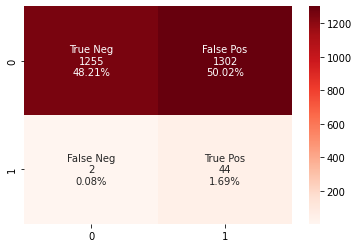

In [36]:
cm = [cm_calib[0][0], cm_calib[0][1], cm_calib[1][0], cm_calib[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')
print("Calibration dataset")

In [37]:
weight_test_predictions = {'Ground Truth': test_labels,
                           'Weighted Classifier prediction': predict_test.ravel().astype(str)}

df_test_predictions = pd.DataFrame(weight_test_predictions)
df_test_predictions.head()

,Ground Truth,Weighted Classifier prediction
0,0,0.7502208
1,0,0.30449307
2,0,0.3040688
3,0,0.7166056
4,0,0.3327837


In [41]:
weight_calib_predictions = {'Ground Truth': calib_labels,
                            'Weighted Classifier prediction': predict_calib.ravel().astype(str)}

df_calib_predictions = pd.DataFrame(weight_calib_predictions)
df_calib_predictions.head(10)

,Ground Truth,Weighted Classifier prediction
0,0,0.71641636
1,0,0.52721894
2,0,0.75397044
3,0,0.3885405
4,0,0.63222814
5,0,0.71430093
6,0,0.29544115
7,0,0.6329002
8,0,0.25886744
9,0,0.6356438


In [42]:
df_calib_predictions.to_csv('/kaggle/working/weight_calib_predictions.csv', index=False)
df_test_predictions.to_csv('/kaggle/working/weight_test_predictions.csv', index=False)